In [ ]:
pip install yfinance


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import yfinance as yf
warnings.filterwarnings('ignore')


Data Collection and Visualization

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


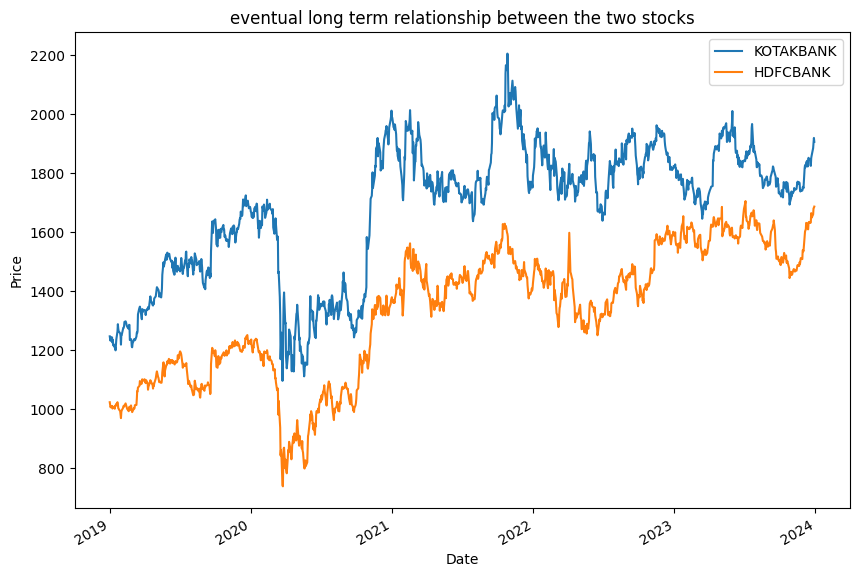

         KOTAKBANK     HDFCBANK
count  1235.000000  1235.000000
mean   1680.212386  1329.926666
std     230.330848   220.177918
min    1094.941895   736.975586
25%    1501.781494  1151.518188
50%    1747.719604  1379.578491
75%    1846.447327  1507.168945
max    2205.384521  1704.918579


In [137]:
enddate='2023-12-31'
startdate='2019-1-1'
x=yf.download('KOTAKBANK.NS',start=startdate,end=enddate)['Adj Close']
y=yf.download('HDFCBANK.NS',start=startdate,end=enddate)['Adj Close']
df=pd.concat([x,y],axis=1)
df.columns=['KOTAKBANK','HDFCBANK']
df.plot(figsize=(10,7))
plt.ylabel('Price')
plt.title('eventual long term relationship between the two stocks')
plt.show()
print(df[['KOTAKBANK', 'HDFCBANK']].describe())  # Check if the asset price columns are populated



In [138]:
correlation = df['KOTAKBANK'].corr(df['HDFCBANK'])
print(f"Correlation between assets: {correlation}")


Correlation between assets: 0.8883323928162706


 Hedge Ratio Calculation Using Linear Regression

In [139]:
#Performing linear regression btwn the two stocks to calculate the hedge ration
X=df['KOTAKBANK']
y=df['HDFCBANK']
model=np.polyfit(X,y,deg=1)
hedge_ratio=model[0]
hr=round(hedge_ratio,3)
print(f'the hedge ratio is {hr}')

the hedge ratio is 0.849


Spread Calculation

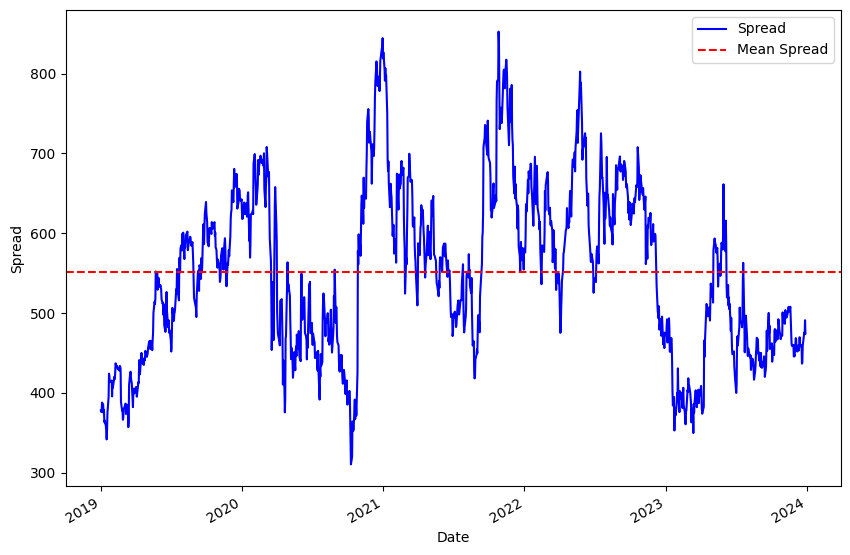

In [140]:
# Calculating the spread
df['Spread']= df.KOTAKBANK - hr *df.HDFCBANK
# Plotting the spread 
df.Spread.plot(figsize=(10,7),color='b')
plt.axhline(df.Spread.mean(), color='red',linestyle='--',label='Mean Spread')
plt.ylabel('Spread')
plt.legend()
plt.show()

Cointegration test using Augmented Dickey-Fuller

In [152]:
from statsmodels.tsa.stattools import adfuller
adf_result=adfuller(df.Spread,maxlag=1)
print('ADF Statistics:', adf_result[0])
print('p-value :',adf_result[1])
print('Criical Values:',adf_result[4])
if adf_result[1]<0.05 :
    print('The spread series is likely stationary')
else :
     print('The spread series is likely not stationary')  




ADF Statistics: -3.9177285913385345
p-value : 0.0019081800047185814
Criical Values: {'1%': -3.435660336370594, '5%': -2.863885022214541, '10%': -2.568018522153254}
The spread series is likely stationary


Simple Mean Reversion strategy

Spread description:
 count    1235.000000
mean      551.104646
std       107.235538
min       310.504055
25%       464.756982
50%       550.979473
75%       630.311051
max       852.527273
Name: Spread, dtype: float64
First few rows of Spread:
               KOTAKBANK     HDFCBANK      Spread
Date                                            
2019-01-01  1246.011719  1022.420654  377.976583
2019-01-02  1236.196655  1013.091919  376.081616
2019-01-03  1230.865601  1005.143127  377.499085
2019-01-04  1243.520508  1007.832458  387.870751
2019-01-07  1242.175293  1009.355408  385.232552
Rolling stats (first 30 rows):
             moving_average  moving_std_dev  upper_band  lower_band
Date                                                              
2019-01-01             NaN             NaN         NaN         NaN
2019-01-02             NaN             NaN         NaN         NaN
2019-01-03             NaN             NaN         NaN         NaN
2019-01-04             NaN             NaN   

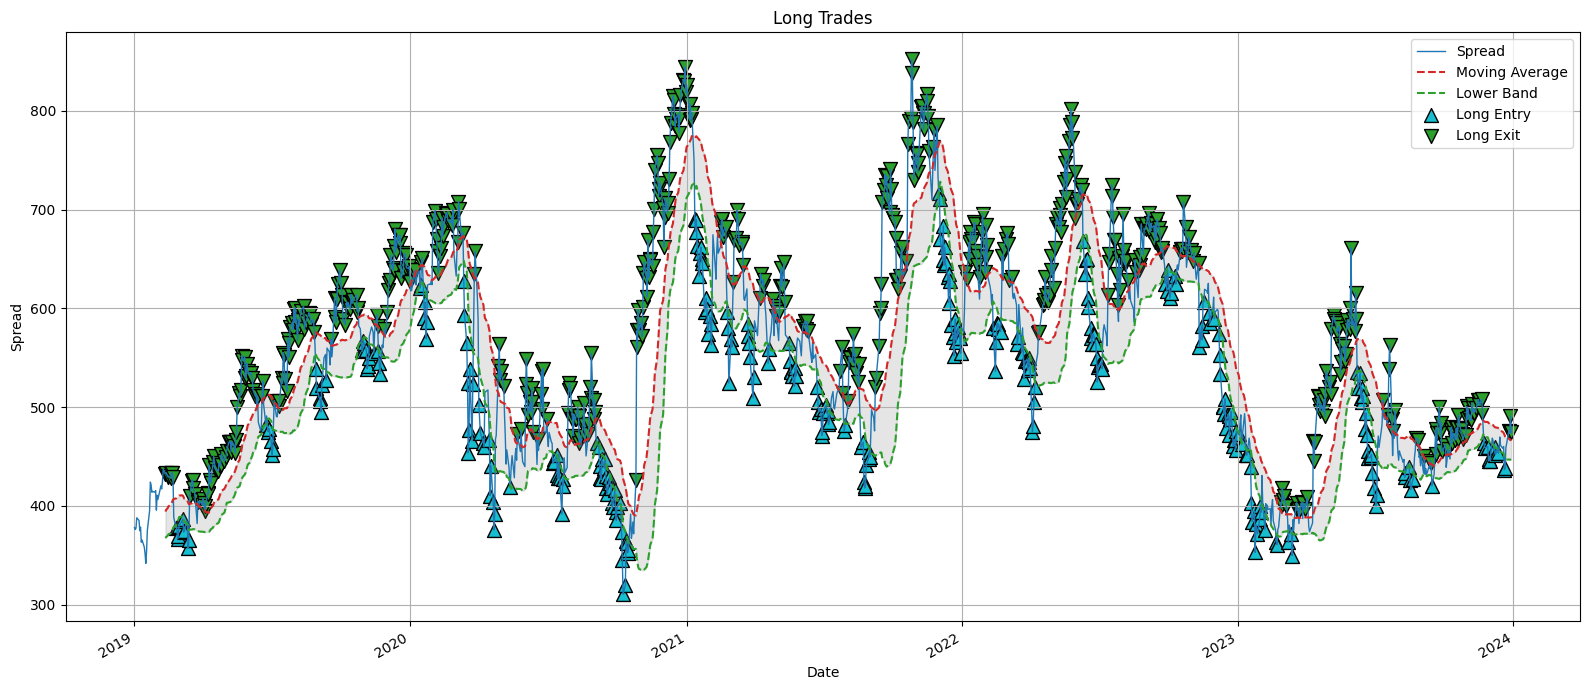

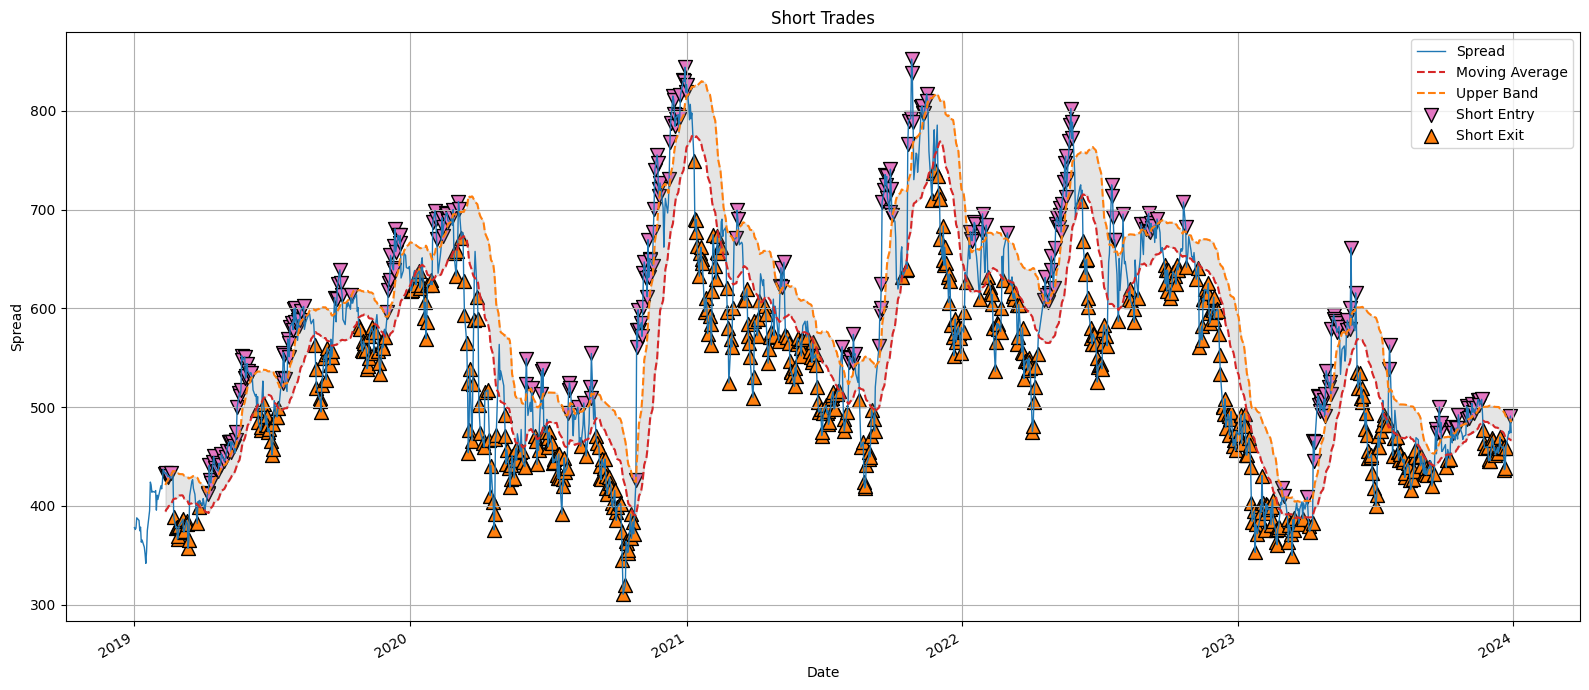

In [ ]:


print("Spread description:\n", df['Spread'].describe())
print("First few rows of Spread:\n", df[['KOTAKBANK', 'HDFCBANK', 'Spread']].head())

df['moving_average'] = df['Spread'].rolling(30).mean()
df['moving_std_dev'] = df['Spread'].rolling(30).std()
df['upper_band'] = df['moving_average'] + 1 * df['moving_std_dev']
df['lower_band'] = df['moving_average'] - 1 * df['moving_std_dev']

print("Rolling stats (first 30 rows):\n", df[['moving_average', 'moving_std_dev', 'upper_band', 'lower_band']].head(30))

df['long_entry'] = (df['Spread'] < df['lower_band'])
df['long_exit'] = (df['Spread'] >= df['moving_average'])
df['short_entry'] = (df['Spread'] > df['upper_band'])
df['short_exit'] = (df['Spread'] <= df['moving_average'])

print("Number of long/short entry and exit signals:\n", df[['long_entry', 'long_exit', 'short_entry', 'short_exit']].sum())
print("Entry signals (first 30 rows):\n", df[['long_entry', 'short_entry']].head(30))

df['positions_long'] = np.nan
df.loc[df['long_entry'], 'positions_long'] = 1
df.loc[df['long_exit'], 'positions_long'] = 0
df['positions_long'] = df['positions_long'].fillna(method='ffill')

df['positions_short'] = np.nan
df.loc[df['short_entry'], 'positions_short'] = -1
df.loc[df['short_exit'], 'positions_short'] = 0
df['positions_short'] = df['positions_short'].fillna(method='ffill')

df['positions'] = df['positions_long'].fillna(0) + df['positions_short'].fillna(0)

print("Positions (last 30 rows):\n", df[['positions_long', 'positions_short', 'positions']].tail(30))

print("NaN values in the data:\n", df.isna().sum())

def plot_long_trades(df):
    plt.figure(figsize=(16, 7))
    df['Spread'].plot(label='Spread', color='#1f77b4', linewidth=1)
    df['moving_average'].plot(label='Moving Average', color='#d62728', linestyle='--')
    df['lower_band'].plot(label='Lower Band', color='#2ca02c', linestyle='--')
    
    plt.scatter(df.index[df['long_entry']], df['Spread'][df['long_entry']], label='Long Entry', marker='^', color='#17becf', s=100, edgecolor='black')
    plt.scatter(df.index[df['long_exit']], df['Spread'][df['long_exit']], label='Long Exit', marker='v', color='#2ca02c', s=100, edgecolor='black')

    plt.fill_between(df.index, df['lower_band'], df['moving_average'], color='gray', alpha=0.2)
    
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title('Long Trades')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_short_trades(df):
    plt.figure(figsize=(16, 7))
    df['Spread'].plot(label='Spread', color='#1f77b4', linewidth=1)
    df['moving_average'].plot(label='Moving Average', color='#d62728', linestyle='--')
    df['upper_band'].plot(label='Upper Band', color='#ff7f0e', linestyle='--')
    
    plt.scatter(df.index[df['short_entry']], df['Spread'][df['short_entry']], label='Short Entry', marker='v', color='#e377c2', s=100, edgecolor='black')
    plt.scatter(df.index[df['short_exit']], df['Spread'][df['short_exit']], label='Short Exit', marker='^', color='#ff7f0e', s=100, edgecolor='black')

    plt.fill_between(df.index, df['moving_average'], df['upper_band'], color='gray', alpha=0.2)
    
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.title('Short Trades')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_long_trades(df)
plot_short_trades(df)



Evaluating the strategy : calculating Cumulative Returns nd Sharpe Ratio

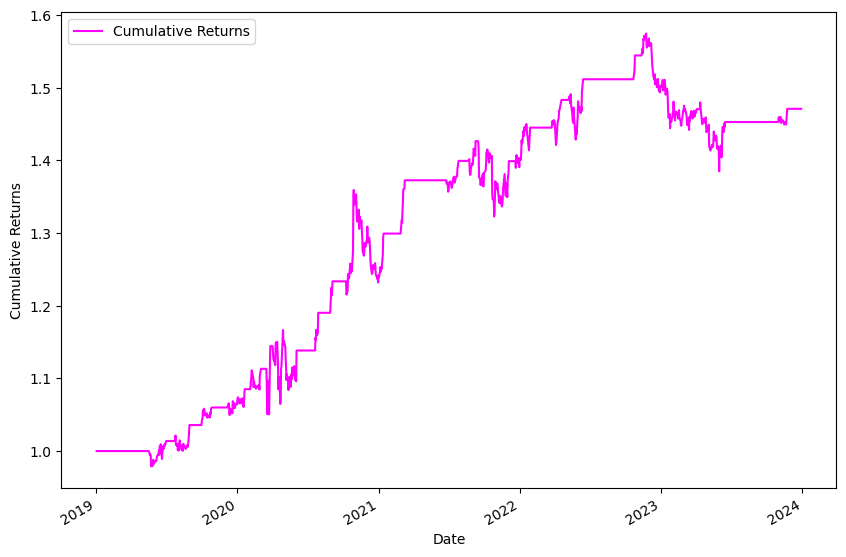

In [150]:
# Calculate percentage change in the spread
df['percentage_change'] = (df['Spread'] - df['Spread'].shift(1)) / (hr * df['HDFCBANK'] + df['KOTAKBANK'])
# Strategy returns: based on the positions and percentage change in the spread
df['strategy_returns'] = df['positions'].shift(1) * df['percentage_change']

# Calculate cumulative returns
df['cumulative_returns'] = (df['strategy_returns'] + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 7))
df['cumulative_returns'].plot(label='Cumulative Returns', color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


In [151]:
sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')


Sharpe Ratio: 0.83


In [146]:
for period in [10, 20, 30, 40, 50, 60]:
    for std_dev in [0.5, 1, 1.5, 2]:
        df = mean_reversion_strategy(df, period, std_dev)
        df['strategy_returns'] = df['positions'].shift(1) * df['percentage_change']
        sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))
        print(f"Period: {period}, Std Dev: {std_dev}, Sharpe Ratio: {np.round(sharpe_ratio, 3)}")


Period: 10, Std Dev: 0.5, Sharpe Ratio: 0.186
Period: 10, Std Dev: 1, Sharpe Ratio: 0.296
Period: 10, Std Dev: 1.5, Sharpe Ratio: 0.484
Period: 10, Std Dev: 2, Sharpe Ratio: 0.379
Period: 20, Std Dev: 0.5, Sharpe Ratio: 0.745
Period: 20, Std Dev: 1, Sharpe Ratio: 0.709
Period: 20, Std Dev: 1.5, Sharpe Ratio: 0.673
Period: 20, Std Dev: 2, Sharpe Ratio: 0.85
Period: 30, Std Dev: 0.5, Sharpe Ratio: 0.843
Period: 30, Std Dev: 1, Sharpe Ratio: 0.78
Period: 30, Std Dev: 1.5, Sharpe Ratio: 1.059
Period: 30, Std Dev: 2, Sharpe Ratio: 1.006
Period: 40, Std Dev: 0.5, Sharpe Ratio: 1.104
Period: 40, Std Dev: 1, Sharpe Ratio: 1.267
Period: 40, Std Dev: 1.5, Sharpe Ratio: 1.02
Period: 40, Std Dev: 2, Sharpe Ratio: 0.899
Period: 50, Std Dev: 0.5, Sharpe Ratio: 0.93
Period: 50, Std Dev: 1, Sharpe Ratio: 1.038
Period: 50, Std Dev: 1.5, Sharpe Ratio: 0.877
Period: 50, Std Dev: 2, Sharpe Ratio: 0.902
Period: 60, Std Dev: 0.5, Sharpe Ratio: 0.825
Period: 60, Std Dev: 1, Sharpe Ratio: 0.893
Period: 60, St

In [147]:
# Drawdown Analysis
df['cumulative_max'] = df['cumulative_returns'].cummax()
df['drawdown'] = (df['cumulative_returns'] - df['cumulative_max']) / df['cumulative_max']
max_drawdown = df['drawdown'].min()
print(f"Max Drawdown: {np.round(max_drawdown * 100, 2)}%")


Max Drawdown: -16.97%


Drawdown Analysis

Maximum drawdown: -16.97%


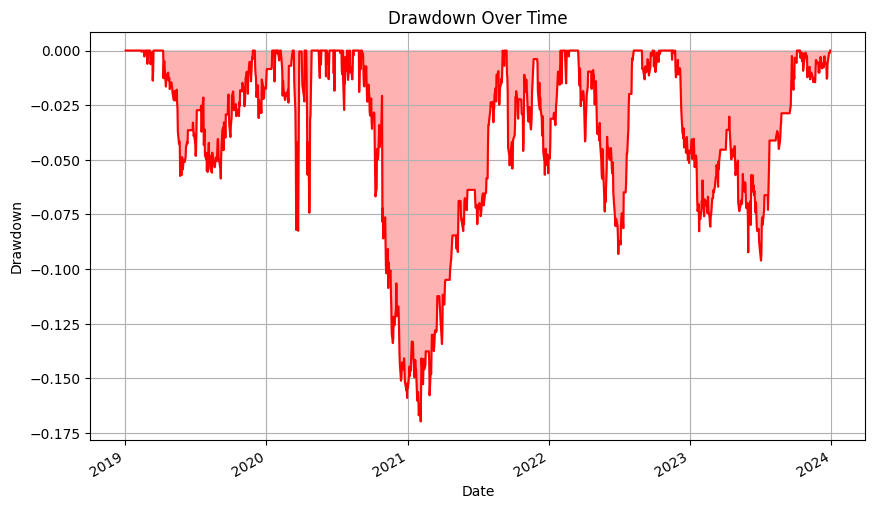

In [148]:
# Drawdown Analysis
# Function to calculate drawdown
def calc_drawdown(cum_rets):
    running_max = np.maximum.accumulate(cum_rets.dropna())
    drawdown = cum_rets / running_max - 1
    return drawdown

# Function to plot drawdown
def plot_drawdown(drawdown):
    drawdown.plot(color='red', figsize=(10, 6))
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown')
    plt.title('Drawdown Over Time')
    plt.grid(True)
    plt.show()

# Calculate drawdown for the strategy
drawdown_strategy = calc_drawdown(df['cumulative_returns'])

# Print maximum drawdown
print("Maximum drawdown: {:.2f}%".format(drawdown_strategy.min() * 100))

# Plot the drawdown
plot_drawdown(drawdown_strategy)


Strategy Comparison with NIFTY

[*********************100%%**********************]  1 of 1 completed


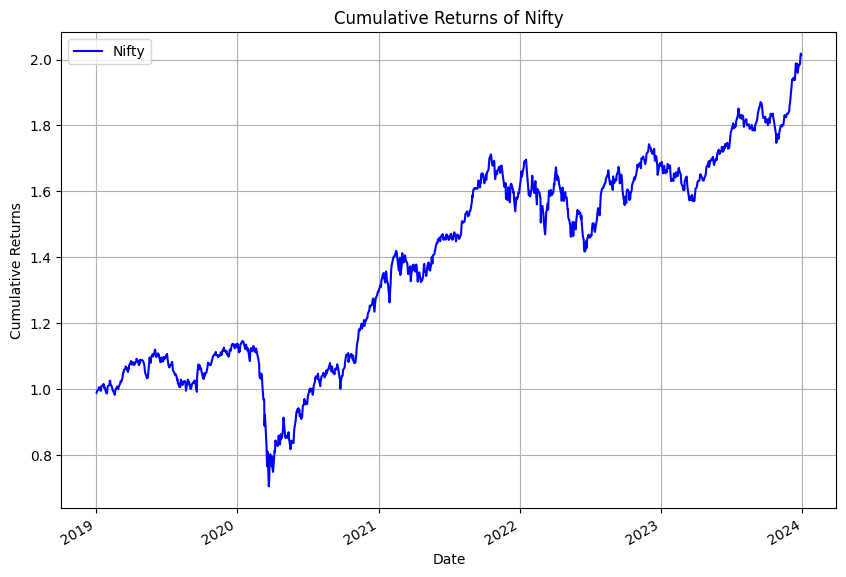

Maximum Nifty drawdown: -38.44%


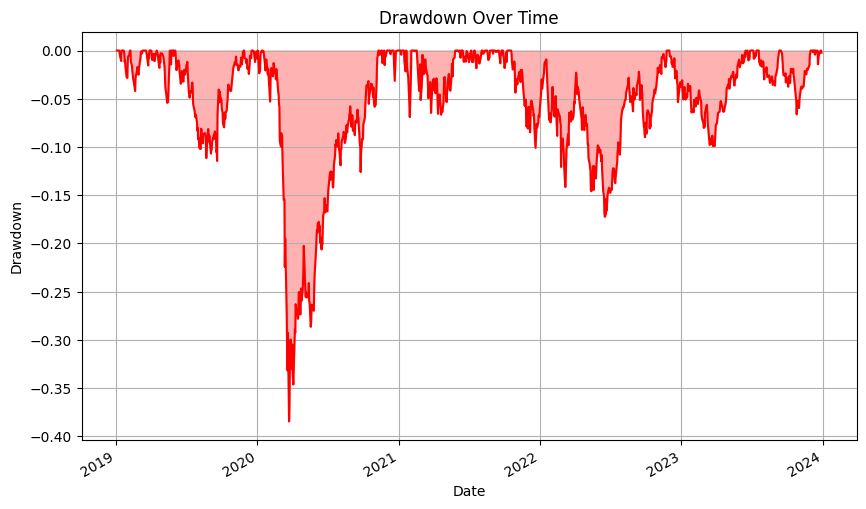

In [154]:
enddate='2023-12-31'
startdate='2019-1-1'
start_date = pd.to_datetime(startdate)
end_date = pd.to_datetime(enddate)

# Downloading Nifty data from Yahoo Finance
nifty = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

# Calculate cumulative returns
nifty_cum_rets = (nifty.pct_change().dropna() + 1).cumprod()

# Plotting cumulative returns of Nifty
plt.figure(figsize=(10, 7))
nifty_cum_rets.plot(label='Nifty', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Nifty')
plt.legend()
plt.grid(True)
plt.show()

# Calculating Nifty drawdown
def calc_drawdown(cum_rets):
    running_max = cum_rets.cummax()
    drawdown = (cum_rets - running_max) / running_max
    return drawdown

def plot_drawdown(drawdown):
    drawdown.plot(color='red', figsize=(10, 6))
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown')
    plt.title('Drawdown Over Time')
    plt.grid(True)
    plt.show()

drawdown_nifty = calc_drawdown(nifty_cum_rets)

# Print maximum drawdown
print("Maximum Nifty drawdown: {:.2f}%".format(drawdown_nifty.min() * 100))

# Plot the Nifty drawdown
plot_drawdown(drawdown_nifty)